In [3]:
!pip install -q kaggle   #install kaggle

In [4]:
from google.colab import files #upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"niloofar1989","key":"81d8de667820abc8414105a455f8abbc"}'}

In [5]:
!mkdir -p ~/.kaggle #hidden folder for kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content/skin_cancer #dataset download

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [01:45<00:00, 66.8MB/s]
100% 5.20G/5.20G [01:45<00:00, 53.0MB/s]


In [7]:
import zipfile
zip_path = "/content/skin_cancer/skin-cancer-mnist-ham10000.zip"   #Extract zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/skin_cancer/")

In [8]:
import pandas as pd

df = pd.read_csv("/content/skin_cancer/HAM10000_metadata.csv") #read from csv file
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Showing image with label

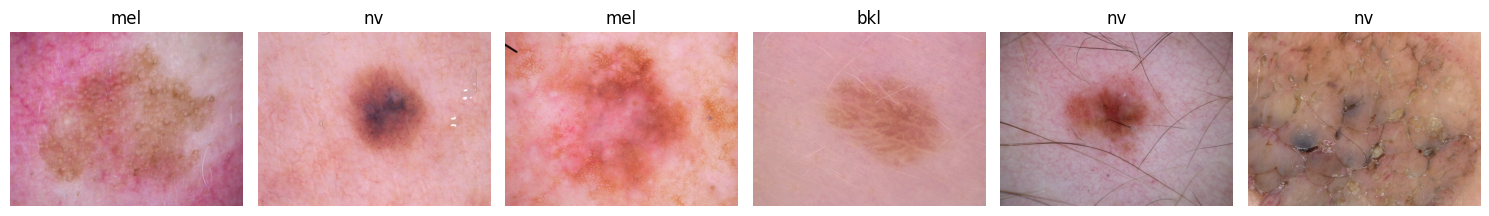

In [9]:
import matplotlib.pyplot as plt
import cv2
import os

img_dir = "/content/skin_cancer/"

samples = df.sample(6, random_state=42) #show image

plt.figure(figsize=(15,5))
for idx, row in enumerate(samples.itertuples()):
    image_path = os.path.join(img_dir, "HAM10000_images_part_1", f"{row.image_id}.jpg")
    if not os.path.exists(image_path):
        image_path = os.path.join(img_dir, "HAM10000_images_part_2", f"{row.image_id}.jpg")

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 6, idx + 1)
    plt.imshow(img)
    plt.title(row.dx)   #label
    plt.axis("off")

plt.tight_layout()
plt.show()


# Binary Classification for Benign(nv) and Melanoma(mel)


In [10]:
import os
from sklearn.model_selection import train_test_split

df_binary = df[df['dx'].isin(['mel', 'nv'])].copy() # we used mel & nv just for binnary classification

df_binary['label'] = df_binary['dx'].map({'nv': 0, 'mel': 1}) # mel = 1 , nv = 0

print(f"number of images: {len(df_binary)}")
df_binary['label'].value_counts()

number of images: 7818


,count
label,
0,6705
1,1113


In [11]:
# split train & val/test
df_train, df_temp = train_test_split(df_binary, test_size=0.3, stratify=df_binary['label'], random_state=42)

# split val & test
df_val, df_test = train_test_split(df_temp, test_size=0.33, stratify=df_temp['label'], random_state=42)

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")


Train: 5472, Val: 1571, Test: 775


In [12]:
import shutil

base_dir = "/content/skin_binary"
# folder path
sets = ['train', 'val', 'test']
classes = ['0', '1']  # 0: nv , 1: mel

for s in sets:
    for c in classes:
        os.makedirs(f"{base_dir}/{s}/{c}", exist_ok=True)

# using function for finding image path
def get_image_path(image_id):
    for part in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
        path = os.path.join("/content/skin_cancer", part, image_id + ".jpg")
        if os.path.exists(path):
            return path
    return None

# using folder structure for better use in PyTorch(split with consider labeling)
def copy_images(df_subset, subset_name):
    for row in df_subset.itertuples():
        src = get_image_path(row.image_id)
        dst = f"{base_dir}/{subset_name}/{row.label}/{row.image_id}.jpg"
        if src:
            shutil.copyfile(src, dst)

copy_images(df_train, 'train')
copy_images(df_val, 'val')
copy_images(df_test, 'test')


In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data Transform (Size Changing + Tensor Trannsform)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Loading train and val
train_ds = datasets.ImageFolder("/content/skin_binary/train", transform=transform_train)
val_ds   = datasets.ImageFolder("/content/skin_binary/val", transform=transform_val)

# loader defining
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # 224x224 → 112x112
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 112x112 → 56x56
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # 56x56 → 28x28
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)  # binary output

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [16]:
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #check for GPU running
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [18]:
def train_model(model, train_loader, val_loader, epochs):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

        # validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                predicted = (outputs > 0.5).int().squeeze()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        acc = correct / total
        print(f"Validation Accuracy: {acc:.4f}")


In [19]:
train_model(model, train_loader, val_loader, epochs=5)

Epoch 1/5, Loss: 0.4139
Validation Accuracy: 0.8574
Epoch 2/5, Loss: 0.3772
Validation Accuracy: 0.8587
Epoch 3/5, Loss: 0.3465
Validation Accuracy: 0.8587
Epoch 4/5, Loss: 0.3198
Validation Accuracy: 0.8593
Epoch 5/5, Loss: 0.3133
Validation Accuracy: 0.8581


In [20]:
torch.save(model.state_dict(), "simple_cnn_skin_cancer.pth") #model saving

In [84]:
from google.colab import files #downloading model
files.download("simple_cnn_skin_cancer.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>